C:\Users\Owner\miniconda\envs\groundwater\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Owner\miniconda\envs\groundwater\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


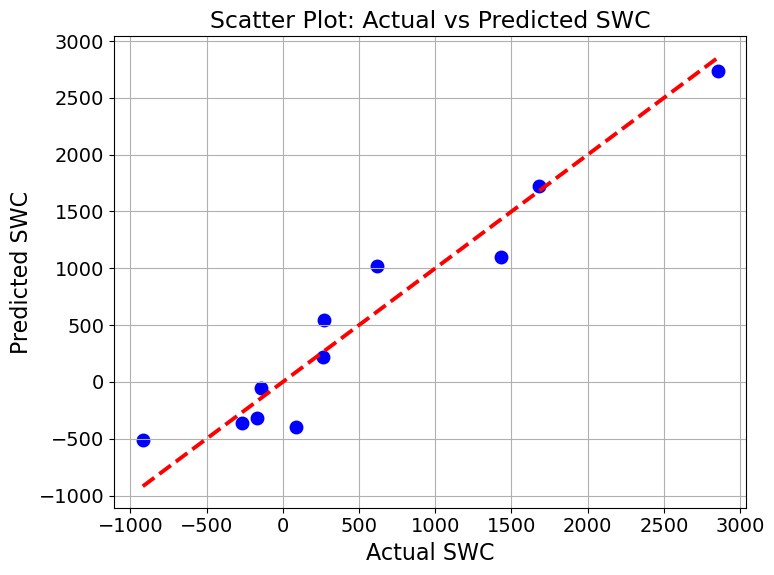

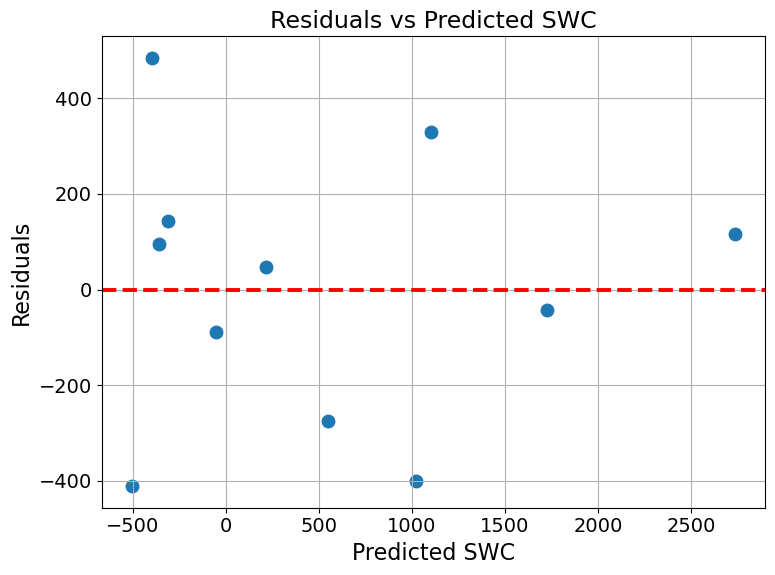

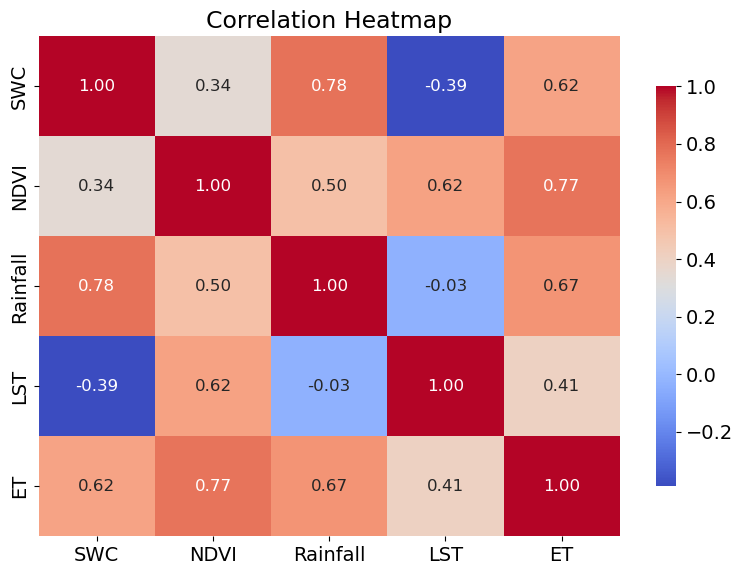

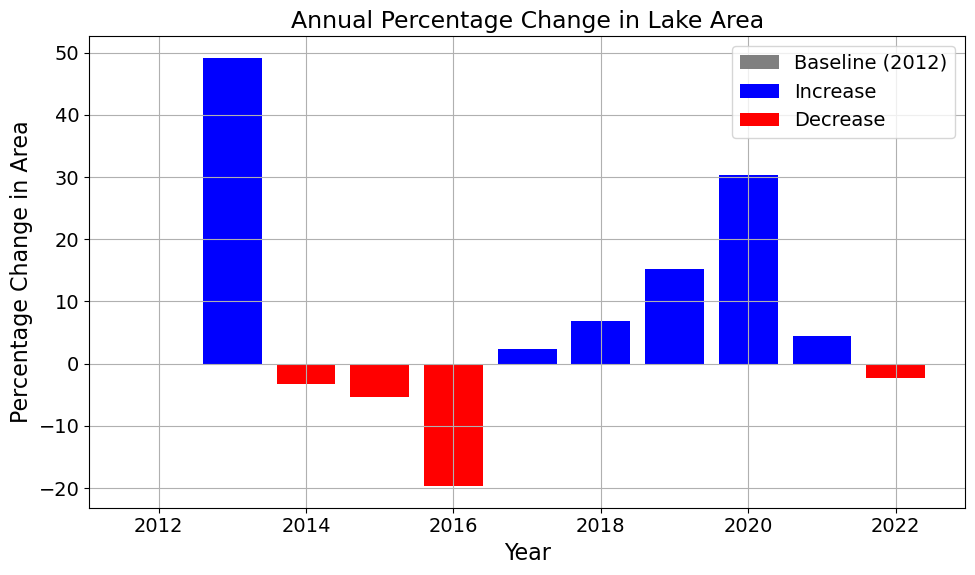

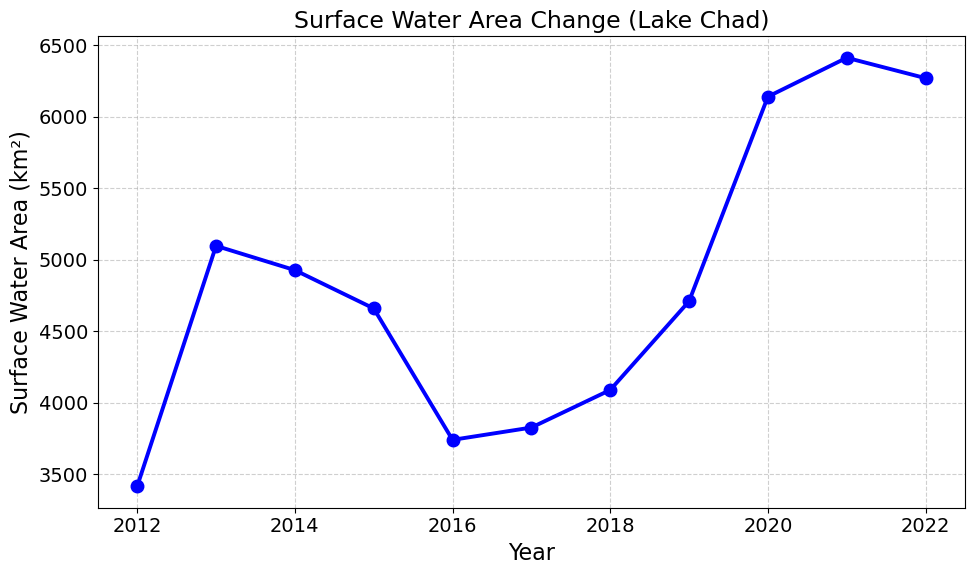

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from matplotlib.patches import Patch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# --- Set directories ---
data_path = r"C:\Users\Owner\Lake_Chad_Analysis"
output_dir = r"C:\Users\Owner"
os.makedirs(output_dir, exist_ok=True)

# --- Set global font and plotting options ---
plt.rcParams.update({
    'font.size': 15,
    'axes.titlesize': 17,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'lines.linewidth': 2.8,
    'lines.markersize': 9
})

# --- Load Data ---
swc_df = pd.read_csv(os.path.join(data_path, 'SWC_Refined.csv'))
ndvi_df = pd.read_csv(os.path.join(data_path, 'NDVI_Refined.csv'))
rain_df = pd.read_csv(os.path.join(data_path, 'Rainfall_Refined.csv'))
lst_df = pd.read_csv(os.path.join(data_path, 'LST_Refined.csv'))
et_df = pd.read_csv(os.path.join(data_path, 'ET_Refined.csv'))

# Merge all data on 'Year'
data = swc_df.merge(ndvi_df, on='Year') \
             .merge(rain_df, on='Year') \
             .merge(lst_df, on='Year') \
             .merge(et_df, on='Year')

# Rename columns for clarity
data.columns = ['Year', 'SWC', 'NDVI', 'Rainfall', 'LST', 'ET']

# --- Regression Analysis ---
X = data[['Rainfall', 'LST', 'NDVI', 'ET']]
y = data['SWC']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
y_pred = model.predict(X_const)

# Save regression summary
with open(os.path.join(output_dir, 'regression_summary.txt'), 'w') as f:
    f.write(model.summary().as_text())

# Save metrics
rmse = mean_squared_error(y, y_pred, squared=False)
mae = mean_absolute_error(y, y_pred)
metrics = pd.DataFrame({
    'Adjusted R²': [model.rsquared_adj],
    'RMSE': [rmse],
    'MAE': [mae]
})
metrics.to_csv(os.path.join(output_dir, 'model_metrics.csv'), index=False)

# --- Plot 1: Actual vs Predicted SWC ---
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, c='blue')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.xlabel('Actual SWC')
plt.ylabel('Predicted SWC')
plt.title('Scatter Plot: Actual vs Predicted SWC')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'scatter_actual_vs_predicted.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 2: Residuals ---
residuals = y - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted SWC')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted SWC')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'residuals_plot.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 3: Correlation Heatmap ---
plt.figure(figsize=(8, 6))
corr_matrix = data[['SWC', 'NDVI', 'Rainfall', 'LST', 'ET']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"size": 12}, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 4: Annual Percentage Area Change ---
area_df = pd.read_csv(os.path.join(data_path, 'Annual_Area_Change.csv'))
years = area_df['Year']
area = area_df['Annual_Area_Change']
area_change_pct = [0] + [(area[i] - area[i - 1]) / area[i - 1] * 100 for i in range(1, len(area))]
bar_colors = ['gray'] + ['blue' if val >= 0 else 'red' for val in area_change_pct[1:]]

plt.figure(figsize=(10, 6))
plt.bar(years, area_change_pct, color=bar_colors)
plt.xlabel('Year')
plt.ylabel('Percentage Change in Area')
plt.title('Annual Percentage Change in Lake Area')
legend_elements = [
    Patch(facecolor='gray', label='Baseline (2012)'),
    Patch(facecolor='blue', label='Increase'),
    Patch(facecolor='red', label='Decrease')
]
plt.legend(handles=legend_elements, loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'percentage_area_change.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 5: Line Plot of Surface Water Area ---
plt.figure(figsize=(10, 6))
plt.plot(years, area, marker='o', color='blue')
plt.xlabel('Year')
plt.ylabel('Surface Water Area (km²)')
plt.title('Surface Water Area Change (Lake Chad)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'surface_water_area_change.png'), dpi=300, bbox_inches='tight')
plt.show()
